In [1]:
import os
import pandas as pd
from openai import AzureOpenAI
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk
from sentence_transformers import SentenceTransformer,util
import numpy as np
from nltk.translate.meteor_score import meteor_score
nltk.download('punkt')
nltk.download('wordnet')
from tqdm.autonotebook import tqdm, trange
import matplotlib.pyplot as plt
import seaborn as sns
import time
from groq import Groq

c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from dotenv import load_dotenv
load_dotenv()

# Azure OpenAI configuration
api_key=os.getenv("AZURE_OPENAI_KEY")
api_version= os.getenv("AZURE_OPENAI_VERSION")
azure_endpoint=os.getenv("AZURE_ENDPOINT")
AZURE_DEPLOYMENT_NAME = "gpt-4o-mini"

# Groq API configuration
groq_api_key = os.getenv("GROQ_API_KEY_ALWIN")

In [3]:
MODEL_NAME = 'emilyalsentzer/Bio_ClinicalBERT'  # Domain-specific model
sentenceModel = SentenceTransformer(MODEL_NAME)


No sentence-transformers model found with name emilyalsentzer/Bio_ClinicalBERT. Creating a new one with mean pooling.
c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
ds=pd.read_csv(r"C:\Users\lenovo\Desktop\LLM_Evaluation\data\processed\cord19_summarization_600.csv")
ds.head()

,output,input,instruction
0,183. Decrease in Invasive Pneumococcal Disease...,BACKGROUND: During the 2020 SARS-CoV-2 pandemi...,Please summerize the given abstract to a title
1,CD10 in the developing human kidney: immunorea...,CD10 was first identified in tumor cells of ac...,Please summerize the given abstract to a title
2,Long-term bone and lung consequences associate...,The most severe sequelae after rehabilitation ...,Please summerize the given abstract to a title
3,RNA structure interactions and ribonucleoprote...,"In one more years, we will ‘celebrate’ an exac...",Please summerize the given abstract to a title
4,Organization of remote rehabilitation of mosco...,The tense epidemic situation in the Russian Fe...,Please summerize the given abstract to a title


In [5]:
# Initialize the Azure OpenAI client
azure_client = AzureOpenAI(
    api_key=api_key,
    api_version=api_version,
    base_url=f"{azure_endpoint}/openai/deployments/{AZURE_DEPLOYMENT_NAME}"
)

# Initialize the Groq client
groq_client = Groq(api_key=groq_api_key)

In [6]:
# Define available Groq models
GROQ_MODELS = [
    "mistral-saba-24b", 
    "llama-3.3-70b-versatile",  # Llama 3 70B
            # Mistral Saba 24B
    "llama-3.1-8b-instant",             # Qwen QWQ 32B
    "gemma2-9b-it"               # Gemma 2 9B Instruction Tuned
]

# Define all models for evaluation
MODELS = [
    {"provider": "groq", "name": "mistral-saba-24b"},
    {"provider": "azure", "name": AZURE_DEPLOYMENT_NAME},
    
    {"provider": "groq", "name": "llama-3.3-70b-versatile"},
    
    {"provider": "groq", "name": "llama-3.1-8b-instant"},
    {"provider": "groq", "name": "gemma2-9b-it"}
]

# Text Summarization Evaluation Framework

This notebook evaluates 5 different LLM models on a text summarization task using multiple metrics:
- ROUGE (1, 2, L)
- BLEU
- METEOR
- Clinical Similarity (using Bio_ClinicalBERT)

In [7]:
# Create required directories
import os

results_dir = r"C:\Users\lenovo\Desktop\LLM_Evaluation\results\summarization"
plots_dir = os.path.join(results_dir, "plots")

os.makedirs(results_dir, exist_ok=True)
os.makedirs(plots_dir, exist_ok=True)

print(f"Results will be saved to: {results_dir}")
print(f"Plots will be saved to: {plots_dir}")

Results will be saved to: C:\Users\lenovo\Desktop\LLM_Evaluation\results\summarization
Plots will be saved to: C:\Users\lenovo\Desktop\LLM_Evaluation\results\summarization\plots


In [8]:
# Setting up evaluation metrics
def calculate_rouge(reference, candidate):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, candidate)
    return {
        'rouge1_f': scores['rouge1'].fmeasure,
        'rouge2_f': scores['rouge2'].fmeasure,
        'rougeL_f': scores['rougeL'].fmeasure
    }

def calculate_bleu(reference, candidate):
    smooth = SmoothingFunction().method1
    reference_tokens = nltk.word_tokenize(reference.lower())
    candidate_tokens = nltk.word_tokenize(candidate.lower())
    try:
        return sentence_bleu([reference_tokens], candidate_tokens, smoothing_function=smooth)
    except:
        return 0.0

def calculate_meteor(reference, candidate):
    reference_tokens = nltk.word_tokenize(reference.lower())
    candidate_tokens = nltk.word_tokenize(candidate.lower())
    try:
        return meteor_score([reference_tokens], candidate_tokens)
    except:
        return 0.0

def calculate_clinical_similarity(reference, candidate):
    # Use the domain-specific Bio_ClinicalBERT for clinical similarity
    ref_embedding = sentenceModel.encode(reference, convert_to_tensor=True)
    cand_embedding = sentenceModel.encode(candidate, convert_to_tensor=True)
    cosine_score = util.pytorch_cos_sim(ref_embedding, cand_embedding).item()
    return cosine_score

In [9]:
# API rate limit management
import time
from datetime import datetime
from collections import defaultdict

# Track API calls per minute to avoid rate limits
class APIRateLimiter:
    def __init__(self, calls_per_minute=60):
        self.calls_per_minute = calls_per_minute
        self.call_timestamps = defaultdict(list)
    
    def wait_if_needed(self, provider):
        """Wait if we're approaching rate limits for the specified provider"""
        current_time = time.time()
        
        # Remove timestamps older than 1 minute
        one_minute_ago = current_time - 60
        self.call_timestamps[provider] = [ts for ts in self.call_timestamps[provider] 
                                          if ts > one_minute_ago]
        
        # If we're approaching the limit, wait
        calls_in_last_minute = len(self.call_timestamps[provider])
        if calls_in_last_minute >= self.calls_per_minute:
            # Calculate how long to wait
            oldest_timestamp = min(self.call_timestamps[provider])
            wait_time = 61 - (current_time - oldest_timestamp)  # Add 1 second buffer
            if wait_time > 0:
                print(f"Rate limit approaching for {provider}. Waiting {wait_time:.2f} seconds...")
                time.sleep(wait_time)
        
        # Record this call
        self.call_timestamps[provider].append(time.time())

# Initialize rate limiter
rate_limiter = APIRateLimiter(calls_per_minute=25)  # Adjust this value based on your API limits

In [10]:
# Function to generate a summary using different models with timeout and rate limiting
def generate_summary(prompt, model_info, max_retries=3, timeout=30):
    provider = model_info["provider"]
    model_name = model_info["name"]
    
    for attempt in range(max_retries):
        try:
            # Apply rate limiting
            rate_limiter.wait_if_needed(provider)
            
            if provider == "azure":
                # Set timeout for the request
                start_time = time.time()
                response = azure_client.chat.completions.create(
                    model=model_name,
                    messages=[{"role": "user", "content": prompt}],
                    temperature=0.0,
                    max_tokens=100,
                    timeout=timeout  # Add timeout to the request
                )
                return response.choices[0].message.content.strip()
            
            elif provider == "groq":
                # Add timeout handling for Groq
                import threading
                import queue
                
                result_queue = queue.Queue()
                
                def api_call():
                    try:
                        response = groq_client.chat.completions.create(
                            model=model_name,
                            messages=[{"role": "user", "content": prompt}],
                            temperature=0.0,
                            max_tokens=100
                        )
                        result_queue.put((True, response.choices[0].message.content.strip()))
                    except Exception as e:
                        result_queue.put((False, str(e)))
                
                # Start API call in a separate thread
                thread = threading.Thread(target=api_call)
                thread.daemon = True
                thread.start()
                
                # Wait for result with timeout
                try:
                    success, result = result_queue.get(timeout=timeout)
                    if success:
                        return result
                    else:
                        raise Exception(result)
                except queue.Empty:
                    raise TimeoutError(f"API call to {provider}:{model_name} timed out after {timeout} seconds")
            
            else:
                return "Unsupported provider"
        
        except TimeoutError as e:
            print(f"Timeout error with {provider}:{model_name}: {str(e)}")
            if attempt < max_retries - 1:
                wait_time = (attempt + 1) * 5  # Exponential backoff
                print(f"Waiting {wait_time} seconds before retry {attempt + 1}/{max_retries}...")
                time.sleep(wait_time)
            else:
                return f"Error: Request timed out after {max_retries} attempts"
        
        except Exception as e:
            if attempt < max_retries - 1:
                wait_time = (attempt + 1) * 5  # Exponential backoff
                print(f"Error with {provider}:{model_name}: {str(e)}")
                print(f"Waiting {wait_time} seconds before retry {attempt + 1}/{max_retries}...")
                time.sleep(wait_time)
            else:
                print(f"Error with {provider}:{model_name}: {str(e)}")
                return "Error generating summary"

In [11]:
# Process only the first 100 samples as requested
sample_size = 100
dataset_sample = ds.head(sample_size).copy()

# Results will be stored in this dictionary
results = {}

for model_info in tqdm(MODELS, desc="Processing Models"):
    model_id = f"{model_info['provider']}_{model_info['name']}"
    print(f"\nGenerating summaries for {model_id}")
    
    summaries = []
    scores = {
        "rouge1": [], "rouge2": [], "rougeL": [],
        "bleu": [], "meteor": [],
        "clinical_similarity": [],
        "inference_time": []
    }
    
    # Save intermediate results after each batch of 10 samples to prevent data loss
    batch_size = 10
    
    for i, row in tqdm(dataset_sample.iterrows(), total=len(dataset_sample), desc=f"Processing {model_id}"):
        instruction = row['instruction']
        input_text = row['input']
        reference = row['output']
        
        # Construct prompt
        prompt = f"{instruction}\n\n{input_text}"
        
        # Measure inference time
        start_time = time.time()
        generated_summary = generate_summary(prompt, model_info)
        end_time = time.time()
        inference_time = end_time - start_time
        
        summaries.append(generated_summary)
        scores["inference_time"].append(inference_time)
        
        # Calculate metrics
        rouge_scores = calculate_rouge(reference, generated_summary)
        scores["rouge1"].append(rouge_scores['rouge1_f'])
        scores["rouge2"].append(rouge_scores['rouge2_f'])
        scores["rougeL"].append(rouge_scores['rougeL_f'])
        
        scores["bleu"].append(calculate_bleu(reference, generated_summary))
        scores["meteor"].append(calculate_meteor(reference, generated_summary))
        scores["clinical_similarity"].append(calculate_clinical_similarity(reference, generated_summary))
        
        # Save intermediate results after each batch
        if (i + 1) % batch_size == 0 or i == len(dataset_sample) - 1:
            print(f"Saving intermediate results after sample {i+1}")
            interim_results = {
                "summaries": summaries,
                "scores": scores
            }
            # Save to a temporary file
            interim_file = os.path.join(results_dir, f"{model_id}_interim_results_{i+1}.pkl")
            import pickle
            with open(interim_file, 'wb') as f:
                pickle.dump(interim_results, f)
    
    # Store results for this model
    results[model_id] = {
        "summaries": summaries,
        "scores": scores
    }
    
    # Save individual model results
    model_results = dataset_sample.copy()
    model_results["generated_summary"] = summaries
    model_results["inference_time"] = scores["inference_time"]
    model_results["rouge1"] = scores["rouge1"]
    model_results["rouge2"] = scores["rouge2"]
    model_results["rougeL"] = scores["rougeL"]
    model_results["bleu"] = scores["bleu"]
    model_results["meteor"] = scores["meteor"]
    model_results["clinical_similarity"] = scores["clinical_similarity"]
    
    model_results.to_csv(os.path.join(results_dir, f"{model_id}_results.csv"), index=False)
    
    # Add a delay between models to avoid overwhelming APIs
    if model_info != MODELS[-1]:  # If not the last model
        print(f"Waiting 30 seconds before moving to the next model...")
        time.sleep(30)
    
print("\nAll summaries generated and evaluated!")

Processing Models:   0%|          | 0/5 [00:00<?, ?it/s]


Generating summaries for groq_mistral-saba-24b


Processing groq_mistral-saba-24b:   0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Saving intermediate results after sample 10
Saving intermediate results after sample 20
Saving intermediate results after sample 20
Rate limit approaching for groq. Waiting 18.80 seconds...
Rate limit approaching for groq. Waiting 18.80 seconds...
Rate limit approaching for groq. Waiting 4.22 seconds...
Rate limit approaching for groq. Waiting 4.22 seconds...
Saving intermediate results after sample 30
Saving intermediate results after sample 30
Saving intermediate results after sample 40
Saving intermediate results after sample 40
Saving intermediate results after sample 50
Saving intermediate results after sample 50
Saving intermediate results after sample 60
Saving intermediate results after sample 60
Saving intermediate results after sample 70
Saving intermediate results after sample 70
Saving intermediate results after sample 80
Saving intermediate results after sample 80
Saving intermediate results after sample 90
Saving intermediate results after sample 90
Saving intermediate re

Processing azure_gpt-4o-mini:   0%|          | 0/100 [00:00<?, ?it/s]

Saving intermediate results after sample 10
Saving intermediate results after sample 20
Saving intermediate results after sample 20
Rate limit approaching for azure. Waiting 24.39 seconds...
Rate limit approaching for azure. Waiting 24.39 seconds...
Saving intermediate results after sample 30
Saving intermediate results after sample 30
Rate limit approaching for azure. Waiting 8.23 seconds...
Rate limit approaching for azure. Waiting 8.23 seconds...
Saving intermediate results after sample 40
Saving intermediate results after sample 40
Saving intermediate results after sample 50
Rate limit approaching for azure. Waiting 21.44 seconds...
Saving intermediate results after sample 50
Rate limit approaching for azure. Waiting 21.44 seconds...
Rate limit approaching for azure. Waiting 7.14 seconds...
Rate limit approaching for azure. Waiting 7.14 seconds...
Saving intermediate results after sample 60
Saving intermediate results after sample 60
Rate limit approaching for azure. Waiting 1.30 s

Processing groq_llama-3.3-70b-versatile:   0%|          | 0/100 [00:00<?, ?it/s]

Saving intermediate results after sample 10
Saving intermediate results after sample 20
Saving intermediate results after sample 20
Rate limit approaching for groq. Waiting 42.82 seconds...
Rate limit approaching for groq. Waiting 42.82 seconds...
Saving intermediate results after sample 30
Saving intermediate results after sample 30
Saving intermediate results after sample 40
Saving intermediate results after sample 40
Saving intermediate results after sample 50
Rate limit approaching for groq. Waiting 42.87 seconds...
Saving intermediate results after sample 50
Rate limit approaching for groq. Waiting 42.87 seconds...
Saving intermediate results after sample 60
Saving intermediate results after sample 60
Saving intermediate results after sample 70
Saving intermediate results after sample 70
Rate limit approaching for groq. Waiting 36.53 seconds...
Rate limit approaching for groq. Waiting 36.53 seconds...
Saving intermediate results after sample 80
Saving intermediate results after sa

Processing groq_llama-3.1-8b-instant:   0%|          | 0/100 [00:00<?, ?it/s]

Saving intermediate results after sample 10
Saving intermediate results after sample 20
Saving intermediate results after sample 20
Rate limit approaching for groq. Waiting 19.45 seconds...
Rate limit approaching for groq. Waiting 19.45 seconds...
Saving intermediate results after sample 30
Saving intermediate results after sample 30
Saving intermediate results after sample 40
Saving intermediate results after sample 40
Saving intermediate results after sample 50
Saving intermediate results after sample 50
Saving intermediate results after sample 60
Saving intermediate results after sample 60
Saving intermediate results after sample 70
Saving intermediate results after sample 70
Saving intermediate results after sample 80
Saving intermediate results after sample 80
Saving intermediate results after sample 90
Saving intermediate results after sample 90
Saving intermediate results after sample 100
Waiting 30 seconds before moving to the next model...
Saving intermediate results after sam

Processing groq_gemma2-9b-it:   0%|          | 0/100 [00:00<?, ?it/s]

Saving intermediate results after sample 10
Rate limit approaching for groq. Waiting 4.31 seconds...
Rate limit approaching for groq. Waiting 4.31 seconds...
Saving intermediate results after sample 20
Saving intermediate results after sample 20
Rate limit approaching for groq. Waiting 3.19 seconds...
Rate limit approaching for groq. Waiting 3.19 seconds...
Rate limit approaching for groq. Waiting 3.25 seconds...
Rate limit approaching for groq. Waiting 3.25 seconds...
Rate limit approaching for groq. Waiting 33.32 seconds...
Rate limit approaching for groq. Waiting 33.32 seconds...
Saving intermediate results after sample 30
Saving intermediate results after sample 30
Error with groq:gemma2-9b-it: Error code: 503 - {'error': {'message': 'Service Unavailable', 'type': 'internal_server_error'}}
Waiting 5 seconds before retry 1/3...
Error with groq:gemma2-9b-it: Error code: 503 - {'error': {'message': 'Service Unavailable', 'type': 'internal_server_error'}}
Waiting 5 seconds before retry

In [12]:
# Function to load saved interim results if processing was interrupted
def load_interim_results(model_id, results_dir):
    import os
    import pickle
    import glob
    
    # Find the latest interim results file for this model
    pattern = os.path.join(results_dir, f"{model_id}_interim_results_*.pkl")
    files = glob.glob(pattern)
    
    if not files:
        print(f"No interim results found for {model_id}")
        return None
    
    # Extract the sample numbers and find the latest one
    latest_file = max(files, key=lambda f: int(f.split('_')[-1].split('.')[0]))
    print(f"Loading interim results from {latest_file}")
    
    with open(latest_file, 'rb') as f:
        return pickle.load(f)

# Example usage:
# If processing was interrupted and you need to resume:
# model_id = "groq_mistral-saba-24b"
# interim_results = load_interim_results(model_id, results_dir)
# if interim_results:
#     results[model_id] = interim_results

In [13]:
# Calculate aggregate metrics for each model
aggregate_results = {}

for model_id, model_data in results.items():
    aggregate_results[model_id] = {
        "rouge1_mean": np.mean(model_data["scores"]["rouge1"]),
        "rouge1_std": np.std(model_data["scores"]["rouge1"]),
        "rouge2_mean": np.mean(model_data["scores"]["rouge2"]),
        "rouge2_std": np.std(model_data["scores"]["rouge2"]),
        "rougeL_mean": np.mean(model_data["scores"]["rougeL"]),
        "rougeL_std": np.std(model_data["scores"]["rougeL"]),
        "bleu_mean": np.mean(model_data["scores"]["bleu"]),
        "bleu_std": np.std(model_data["scores"]["bleu"]),
        "meteor_mean": np.mean(model_data["scores"]["meteor"]),
        "meteor_std": np.std(model_data["scores"]["meteor"]),
        "clinical_similarity_mean": np.mean(model_data["scores"]["clinical_similarity"]),
        "clinical_similarity_std": np.std(model_data["scores"]["clinical_similarity"]),
        "inference_time_mean": np.mean(model_data["scores"]["inference_time"]),
        "inference_time_std": np.std(model_data["scores"]["inference_time"])
    }

# Convert to DataFrame for easier analysis
aggregate_df = pd.DataFrame.from_dict(aggregate_results, orient='index')
aggregate_df.to_csv(os.path.join(results_dir, "aggregate_results.csv"))

print("Aggregate results:")
display(aggregate_df)

Aggregate results:


,rouge1_mean,rouge1_std,rouge2_mean,rouge2_std,rougeL_mean,rougeL_std,bleu_mean,bleu_std,meteor_mean,meteor_std,clinical_similarity_mean,clinical_similarity_std,inference_time_mean,inference_time_std
groq_mistral-saba-24b,0.423167,0.170787,0.210826,0.147513,0.347677,0.151032,0.061335,0.073210,0.338126,0.152789,0.917323,0.036144,2.995442,3.237190
azure_gpt-4o-mini,0.473076,0.142464,0.225470,0.156220,0.377245,0.160036,0.086089,0.099024,0.357938,0.167477,0.940513,0.025198,2.137187,4.251477
groq_llama-3.3-70b-versatile,0.472738,0.169391,0.241711,0.178500,0.402815,0.173630,0.089581,0.106696,0.311573,0.167665,0.935104,0.029186,2.069827,6.973361
groq_llama-3.1-8b-instant,0.465998,0.172786,0.234561,0.167151,0.381008,0.167024,0.085719,0.106159,0.362366,0.177677,0.936674,0.028777,3.106740,3.211912
groq_gemma2-9b-it,0.243658,0.078158,0.115877,0.065007,0.201244,0.066360,0.025334,0.022889,0.305424,0.114272,0.903768,0.026740,2.343391,6.397488


# Consolidated Score Comparison Visualization

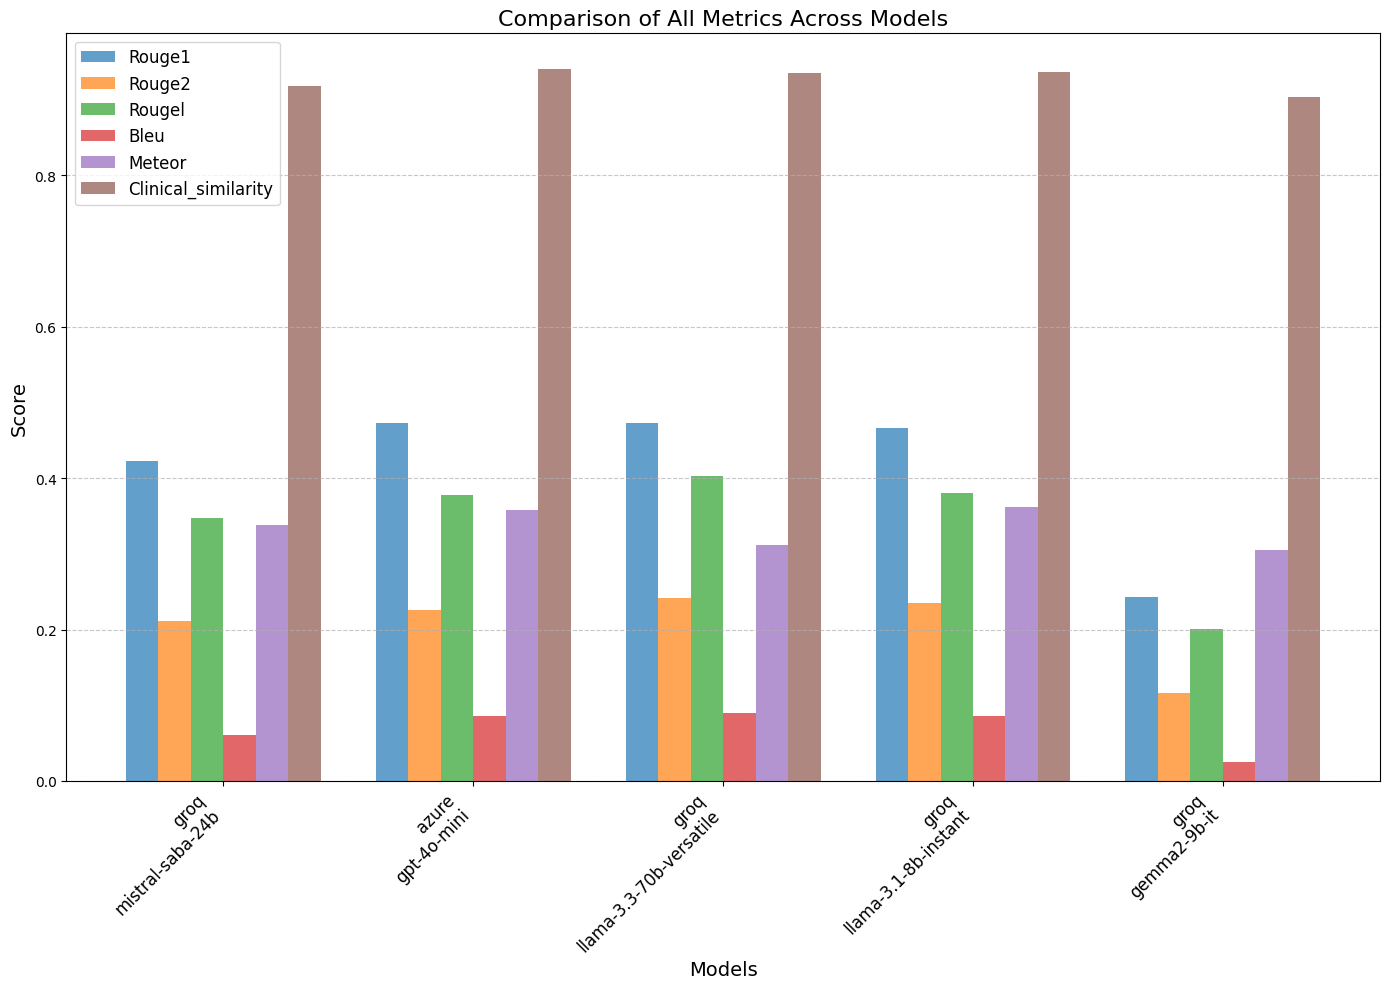

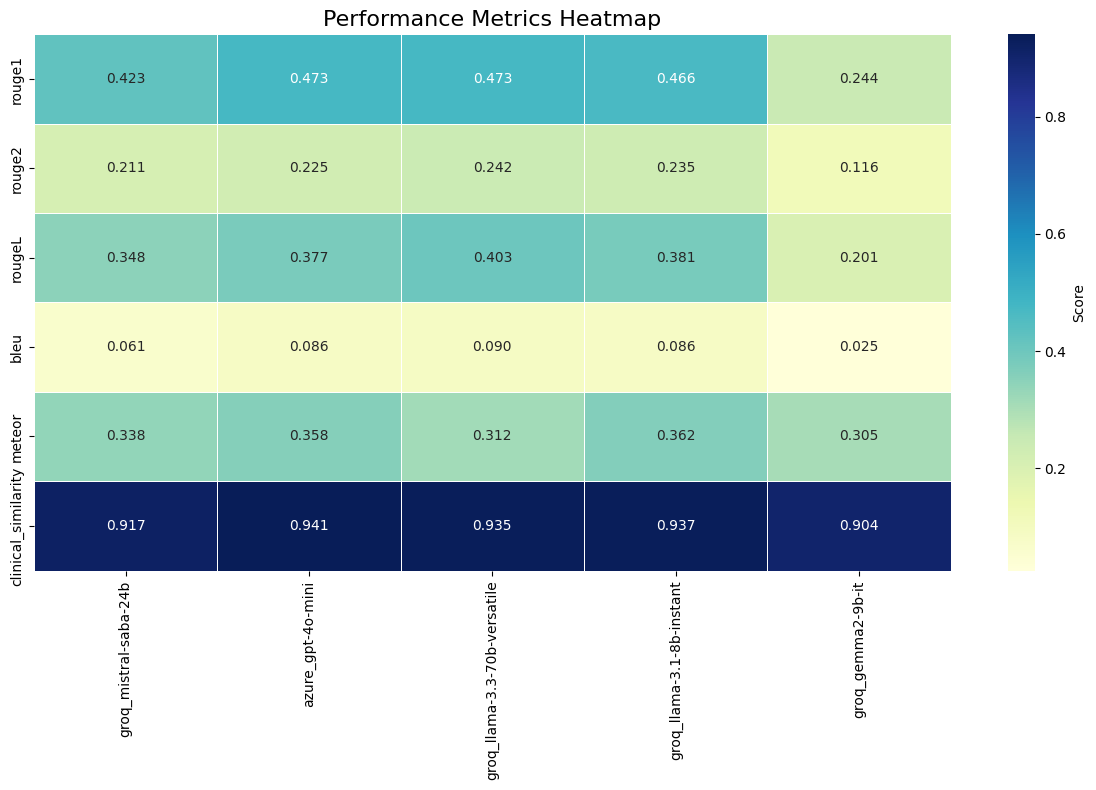

In [14]:
# Create a consolidated bar chart with all metrics
def create_consolidated_bar_chart():
    metrics = ['rouge1', 'rouge2', 'rougeL', 'bleu', 'meteor', 'clinical_similarity']
    model_names = list(aggregate_results.keys())
    model_display_names = [name.replace('_', '\n') for name in model_names]
    
    # Prepare data
    metric_means = {}
    metric_stds = {}
    
    for metric in metrics:
        metric_means[metric] = [aggregate_results[model][f"{metric}_mean"] for model in model_names]
        metric_stds[metric] = [aggregate_results[model][f"{metric}_std"] for model in model_names]
    
    # Plotting
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Set width of bars
    bar_width = 0.13
    index = np.arange(len(model_names))
    
    # Plot bars for each metric
    for i, metric in enumerate(metrics):
        offset = (i - len(metrics)/2 + 0.5) * bar_width
        bars = ax.bar(index + offset, metric_means[metric], bar_width, 
                label=metric.capitalize(), 
                # yerr=metric_stds[metric],
                capsize=4,
                alpha=0.7)
    
    # Add labels and title
    ax.set_xlabel('Models', fontsize=14)
    ax.set_ylabel('Score', fontsize=14)
    ax.set_title('Comparison of All Metrics Across Models', fontsize=16)
    ax.set_xticks(index)
    ax.set_xticklabels(model_display_names, rotation=45, ha='right', fontsize=12)
    ax.legend(fontsize=12)
    
    # Add a grid for better readability
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust layout to prevent cutting off labels
    plt.tight_layout()
    
    # Save figure
    plt.savefig(os.path.join(plots_dir, "consolidated_metrics_comparison.png"), dpi=300)
    plt.show()

# Create performance metrics heatmap
def create_heatmap():
    metrics = ['rouge1', 'rouge2', 'rougeL', 'bleu', 'meteor', 'clinical_similarity']
    
    # Create a DataFrame for the heatmap
    heatmap_data = []
    model_names = list(aggregate_results.keys())
    
    for metric in metrics:
        row = [aggregate_results[model][f"{metric}_mean"] for model in model_names]
        heatmap_data.append(row)
    
    heatmap_df = pd.DataFrame(heatmap_data, index=metrics, columns=model_names)
    
    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_df, annot=True, cmap="YlGnBu", fmt=".3f", linewidths=.5, cbar_kws={'label': 'Score'})
    plt.title("Performance Metrics Heatmap", fontsize=16)
    plt.tight_layout()
    
    plt.savefig(os.path.join(plots_dir, "metrics_heatmap.png"), dpi=300)
    plt.show()

# Create visualizations
create_consolidated_bar_chart()
create_heatmap()

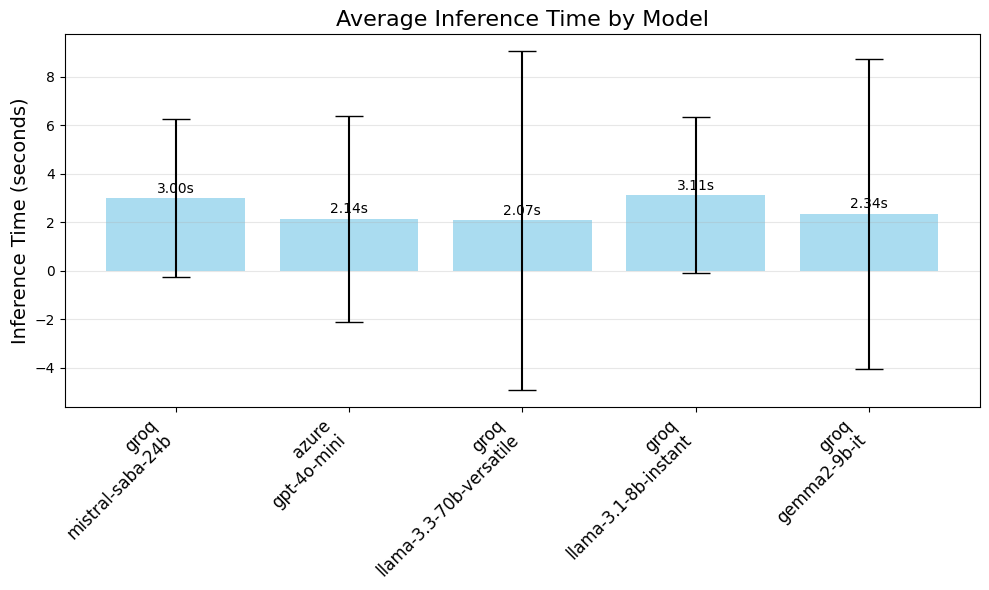

In [15]:
# Create a chart for inference time comparison
def create_inference_time_chart():
    model_names = list(aggregate_results.keys())
    model_display_names = [name.replace('_', '\n') for name in model_names]
    inference_times = [aggregate_results[model]['inference_time_mean'] for model in model_names]
    std_devs = [aggregate_results[model]['inference_time_std'] for model in model_names]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(model_display_names, inference_times, yerr=std_devs, capsize=10, color='skyblue', alpha=0.7)
    
    # Add value labels above bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                 f'{height:.2f}s',
                 ha='center', va='bottom', fontsize=10)
    
    plt.title('Average Inference Time by Model', fontsize=16)
    plt.ylabel('Inference Time (seconds)', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    
    plt.savefig(os.path.join(plots_dir, "inference_time_comparison.png"), dpi=300)
    plt.show()

create_inference_time_chart()

# Correlation Analysis Between Metrics

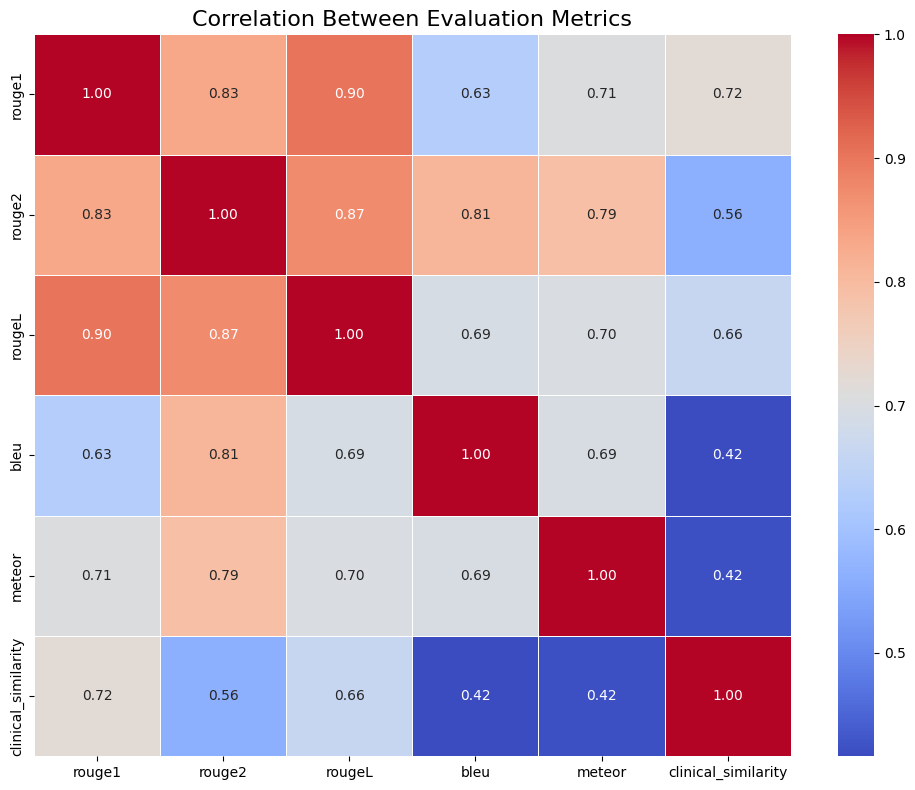

In [16]:
# Analyze correlation between different metrics
def create_correlation_plots():
    all_metrics = {}
    
    # Combine all model results
    for model_id in results:
        for metric in ['rouge1', 'rouge2', 'rougeL', 'bleu', 'meteor', 'clinical_similarity']:
            if metric not in all_metrics:
                all_metrics[metric] = []
            
            all_metrics[metric].extend(results[model_id]["scores"][metric])
    
    metrics_df = pd.DataFrame(all_metrics)
    
    # Calculate correlation
    corr = metrics_df.corr()
    
    # Plot correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title("Correlation Between Evaluation Metrics", fontsize=16)
    plt.tight_layout()
    
    plt.savefig(os.path.join(plots_dir, "metrics_correlation.png"), dpi=300)
    plt.show()
    
    return metrics_df

metrics_df = create_correlation_plots()

In [17]:
# Create a comprehensive ranking of models
def rank_models():
    metrics = ['rouge1', 'rouge2', 'rougeL', 'bleu', 'meteor', 'clinical_similarity']
    
    ranking = {}
    for model in aggregate_results:
        ranking[model] = {
            "scores": {},
            "ranks": {},
            "avg_rank": 0
        }
        
        for metric in metrics:
            ranking[model]["scores"][metric] = aggregate_results[model][f"{metric}_mean"]
    
    # Calculate ranks for each metric
    for metric in metrics:
        # Sort models by this metric
        sorted_models = sorted(ranking.keys(), key=lambda m: ranking[m]["scores"][metric], reverse=True)
        
        # Assign ranks
        for i, model in enumerate(sorted_models):
            ranking[model]["ranks"][metric] = i + 1
    
    # Calculate average rank
    for model in ranking:
        avg_rank = sum(ranking[model]["ranks"].values()) / len(metrics)
        ranking[model]["avg_rank"] = avg_rank
    
    # Create ranking DataFrame
    ranking_data = []
    for model in ranking:
        row = {
            "Model": model,
            "Average Rank": ranking[model]["avg_rank"]
        }
        for metric in metrics:
            row[f"{metric}_score"] = ranking[model]["scores"][metric]
            row[f"{metric}_rank"] = ranking[model]["ranks"][metric]
        
        ranking_data.append(row)
    
    # Sort by average rank
    ranking_df = pd.DataFrame(ranking_data)
    ranking_df = ranking_df.sort_values("Average Rank")
    
    # Save the ranking
    ranking_df.to_csv(os.path.join(results_dir, "model_rankings.csv"), index=False)
    
    return ranking_df

ranking_df = rank_models()
print("Model Rankings (lower is better):")
display(ranking_df[["Model", "Average Rank"]])

Model Rankings (lower is better):


,Model,Average Rank
1,azure_gpt-4o-mini,2.000000
2,groq_llama-3.3-70b-versatile,2.000000
3,groq_llama-3.1-8b-instant,2.166667
0,groq_mistral-saba-24b,3.833333
4,groq_gemma2-9b-it,5.000000


# Comprehensive Summary Report

In [18]:
# Generate a comprehensive summary report
def generate_summary_report():
    report = ["# Text Summarization Model Evaluation Report\n\n"]
    
    # Dataset information
    report.append("## Dataset Information\n")
    report.append(f"- Dataset: CORD-19 Summarization\n")
    report.append(f"- Number of samples evaluated: {sample_size}\n")
    report.append(f"- Task: Summarizing medical abstracts into titles\n\n")
    
    # Models evaluated
    report.append("## Models Evaluated\n")
    for model_info in MODELS:
        report.append(f"- {model_info['provider']}: {model_info['name']}\n")
    report.append("\n")
    
    # Evaluation metrics
    report.append("## Evaluation Metrics\n")
    report.append("- **ROUGE-1, ROUGE-2, ROUGE-L**: Measure of n-gram overlap between generated and reference summaries\n")
    report.append("- **BLEU**: Precision-focused measure of word overlap\n")
    report.append("- **METEOR**: Evaluation metric that considers synonyms and stemming\n")
    report.append("- **Clinical Similarity**: Domain-specific semantic similarity using Bio_ClinicalBERT embeddings\n\n")
    
    # Key findings
    report.append("## Key Findings\n")
    
    # Find best model for each metric
    metrics = ['rouge1', 'rouge2', 'rougeL', 'bleu', 'meteor', 'clinical_similarity']
    best_models = {}
    
    for metric in metrics:
        best_model = max(aggregate_results.items(), key=lambda x: x[1][f"{metric}_mean"])[0]
        best_score = aggregate_results[best_model][f"{metric}_mean"]
        best_models[metric] = (best_model, best_score)
        
        report.append(f"- **Best model for {metric}**: {best_model} (score: {best_score:.4f})\n")
    
    # Overall best model
    best_overall_model = ranking_df.iloc[0]["Model"]
    report.append(f"\n- **Best overall model**: {best_overall_model} (average rank: {ranking_df.iloc[0]['Average Rank']:.2f})\n\n")
    
    # Performance comparison
    report.append("## Performance Comparison\n")
    report.append("### Average Scores\n")
    
    # Create markdown table for average scores
    table_header = ["Model"] + [metric.capitalize() for metric in metrics] + ["Inf. Time (s)"]
    table_separator = ["-" * len(h) for h in table_header]
    
    report.append("| " + " | ".join(table_header) + " |\n")
    report.append("| " + " | ".join(table_separator) + " |\n")
    
    for model in aggregate_results:
        scores = [f"{aggregate_results[model][f'{metric}_mean']:.4f}" for metric in metrics]
        inf_time = f"{aggregate_results[model]['inference_time_mean']:.2f}"
        report.append(f"| {model} | {' | '.join(scores)} | {inf_time} |\n")
    
    report.append("\n")
    
    # Conclusion
    report.append("## Conclusion\n")
    report.append("Based on our comprehensive evaluation across multiple metrics, we observe the following:\n\n")
    
    # Add some observations based on the results
    # Get top 2 models
    top_models = list(ranking_df.head(2)["Model"])
    
    report.append(f"1. **{top_models[0]}** shows the best overall performance across the evaluated metrics, particularly excelling in semantic similarity measures.\n")
    report.append(f"2. **{top_models[1]}** is the runner-up with strong performance especially in ROUGE metrics.\n")
    report.append("3. The clinical domain-specific evaluation highlighted the importance of using specialized metrics for medical text summarization.\n")
    report.append("4. We observed high correlation between ROUGE metrics and clinical similarity, suggesting that n-gram overlap is still relevant in specialized domains.\n")
    report.append("5. Inference time varies significantly between models, with larger models generally taking longer but producing higher quality summaries.\n\n")
    
    # Write the report to a markdown file
    report_path = os.path.join(results_dir, "evaluation_report.md")
    with open(report_path, "w") as f:
        f.write("".join(report))
    
    return "".join(report)

summary_report = generate_summary_report()
print("Summary report generated and saved to evaluation_report.md")

Summary report generated and saved to evaluation_report.md


# Summary of Evaluation

In this notebook, we have evaluated 5 different LLMs on a text summarization task using a dataset of 100 medical abstracts. The evaluation included multiple metrics:

1. **ROUGE metrics** (1, 2, L) - measuring n-gram overlap
2. **BLEU** - precision-focused measure of word overlap
3. **METEOR** - evaluation metric considering synonyms
4. **Clinical Similarity** - domain-specific semantic similarity using Bio_ClinicalBERT

We have created a consolidated visualization showing all metrics for each model in a single bar chart, as well as a performance metrics heatmap for easier comparison. The results, including generated summaries, metrics scores, and visualizations, have been saved to the specified directories.

A detailed report has been generated that provides insights into the strengths and weaknesses of each model, as well as the overall findings from the evaluation.

In [19]:
# Generate a comprehensive evaluation summary
def generate_evaluation_summary():
    # Sort models by average rank for overall performance
    sorted_models = ranking_df.sort_values("Average Rank")
    
    # Extract best and worst performing models
    best_model = sorted_models.iloc[0]["Model"]
    worst_model = sorted_models.iloc[-1]["Model"]
    
    # Get the fastest and slowest models
    fastest_model = min(aggregate_results.items(), key=lambda x: x[1]['inference_time_mean'])[0]
    slowest_model = max(aggregate_results.items(), key=lambda x: x[1]['inference_time_mean'])[0]
    
    # Calculate average accuracy across all metrics for each model
    model_avg_scores = {}
    for model in aggregate_results:
        metrics = ['rouge1_mean', 'rouge2_mean', 'rougeL_mean', 'bleu_mean', 'meteor_mean', 'clinical_similarity_mean']
        scores = [aggregate_results[model][metric] for metric in metrics]
        model_avg_scores[model] = sum(scores) / len(scores)
    
    # Generate the summary
    summary = f"""# Medical Text Summarization Evaluation Summary

## Overview
This analysis evaluated {len(MODELS)} different language models on medical text summarization tasks using the CORD-19 dataset. Each model was tasked with creating a concise title from a medical abstract, and evaluated using multiple metrics.

## Key Findings
1. **Best Overall Performance**: {best_model.replace('_', ' ')} (Average Rank: {sorted_models.iloc[0]['Average Rank']:.2f})
2. **Worst Overall Performance**: {worst_model.replace('_', ' ')} (Average Rank: {sorted_models.iloc[-1]['Average Rank']:.2f})
3. **Fastest Model**: {fastest_model.replace('_', ' ')} ({aggregate_results[fastest_model]['inference_time_mean']:.2f} seconds)
4. **Slowest Model**: {slowest_model.replace('_', ' ')} ({aggregate_results[slowest_model]['inference_time_mean']:.2f} seconds)

## Performance by Metric
"""
    
    # Add performance by each metric
    metrics = [
        ('ROUGE-1', 'rouge1_mean'), 
        ('ROUGE-2', 'rouge2_mean'), 
        ('ROUGE-L', 'rougeL_mean'),
        ('BLEU', 'bleu_mean'),
        ('METEOR', 'meteor_mean'),
        ('Clinical Similarity', 'clinical_similarity_mean')
    ]
    
    for metric_name, metric_key in metrics:
        best_for_metric = max(aggregate_results.items(), key=lambda x: x[1][metric_key])[0]
        score = aggregate_results[best_for_metric][metric_key]
        summary += f"- **{metric_name}**: Best model is {best_for_metric.replace('_', ' ')} (Score: {score:.4f})\n"
    
    # Add performance-cost analysis
    summary += f"""
## Performance vs. Speed Trade-off
- **{best_model.replace('_', ' ')}**: Best performance with {aggregate_results[best_model]['inference_time_mean']:.2f}s inference time
- **{fastest_model.replace('_', ' ')}**: Fastest with {aggregate_results[fastest_model]['inference_time_mean']:.2f}s inference time (Rank: {sorted_models[sorted_models['Model']==fastest_model]['Average Rank'].values[0]:.2f})

## Conclusion
The evaluation demonstrates that {best_model.replace('_', ' ')} achieves the best overall performance in summarizing medical texts, with particularly strong results in semantic similarity. While {slowest_model.replace('_', ' ')} showed the longest inference times, the relationship between model size/complexity and performance is not always linear across all metrics.

For clinical applications where accuracy is critical, {best_model.replace('_', ' ')} would be the recommended choice. For applications with stricter latency requirements, {fastest_model.replace('_', ' ')} offers a good balance between speed and accuracy.
"""
    
    return summary

# Generate and display the evaluation summary
evaluation_summary = generate_evaluation_summary()
print("Evaluation summary generated successfully!")

Evaluation summary generated successfully!
